In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../paleopy/')

In [33]:
# %%writefile /Users/nicolasf/CODE/paleopy/paleopy/core/analogs.py
import os
import numpy as np
from numpy import ma
import json
import xray
import bottleneck  as bn
from matplotlib.mlab import detrend_linear
from scipy.stats import ttest_ind
# from ..utils import seasons_params
from utils import seasons_params

class analogs:
    """
    base class for analogs calculations,
    takes either a `proxy` or `ensemble` instance
    """
    def __init__(self, obj, dataset, variable):
        super(analogs, self).__init__()
        # the parent can be either an instance of a `proxy` or `ensemble` class
        self.parent = obj
        # the dataset to read from
        self.dataset = dataset
        # the variable to read
        self.variable = variable
        # the season is an attribute of the parent object
        # if the parent is an ensemble, the consistency has
        # already been checked
        self.season = self.parent.season
        self.analog_years = self.parent.analog_years
        self.detrend = self.parent.detrend

    def _read_dset_params(self):
        """
        reads in the Dataset parameters
        """
        with open(os.path.join(self.parent.djsons, 'datasets.json'), 'r') as f:
            dset_dict = json.loads(f.read())
        # dset_dict is a dictionnary holding useful metadata
        self.dset_dict = dset_dict[self.dataset][self.variable]

    def _check_domain(self, domain):
        if not(hasattr(self, 'dset_dict')):
            self._read_dset_params()
        self.domain = domain
        domain_dset = self.dset_dict['domain']
        if ( (self.domain[0] < domain_dset[0]) | (self.domain[1] > domain_dset[1])  \
            | (self.domain[2] < domain_dset[2]) | (self.domain[3] > domain_dset[3]) ):
            print("""ERROR! the domain for the composite is partly outside the limits of the dataset""")
            raise Exception("DOMAIN ERROR")

    def calculate_season(self):
        """
        calculates the season
        """
        self.seasons_params = seasons_params()

        if not(hasattr(self, 'dset_dict')):
            self._read_dset_params()

        # get the name of the file to open
        fname = self.dset_dict['path']

        # `dset` is now an attribute of the ensemble object
        self.dset = xray.open_dataset(fname)

        # get the variable and its index
        m_var = self.dset[self.variable].data
        index = self.dset['time'].to_index()

        # if the variable is rainfall, we calculate the running SUM
        if self.dset_dict['units'] in ['mm']:
            seas_field = bn.move_sum(m_var, self.seasons_params[self.season][0], \
                                          min_count=self.seasons_params[self.season][0], axis=0)
        # if not, then we calculate the running MEAN (average)
        else:
            seas_field = bn.move_mean(m_var, self.seasons_params[self.season][0], \
                                          min_count=self.seasons_params[self.season][0], axis=0)

        # get rid of the first nans in the time-series / fields after move_mean or move_sum
        seas_field = seas_field[(self.seasons_params[self.season][0]-1)::,:,:]
        index = index[(self.seasons_params[self.season][0]-1)::]

        # now selects the SEASON of interest
        iseas = np.where(index.month == self.seasons_params[self.season][1])[0]
        dates = index[iseas]
        seas_field = np.take(seas_field, iseas, axis=0)

        # if detrend is set to `True`, we detrend
        # detrend_linear from matplotlib.mlab is faster than detrend from scipy.signal
        if self.detrend:
            dseas_field = np.ones(seas_field.shape) * np.nan
            # if there is a mask, we have to test each variable
            if 'mask' in self.dset.data_vars:
                for ilat in range(dseas_field.shape[1]):
                    for ilon in range(dseas_field.shape[2]):
                        if np.logical_not(np.all(np.isnan(seas_field[:,ilat, ilon]))):
                            dseas_field[:,ilat, ilon] = detrend_linear(seas_field[:,ilat,ilon]) \
                            + seas_field[:,ilat,ilon].mean()

            # if not, we can proceed over the whole dataset
            else:
                for ilat in range(dseas_field.shape[1]):
                    for ilon in range(dseas_field.shape[2]):
                        dseas_field[:,ilat, ilon] = detrend_linear(seas_field[:,ilat,ilon]) \
                        + seas_field[:,ilat,ilon].mean()

            self.dset['dates'] = (('dates',), dates)
            self.dset['seas_var'] = (('dates', 'latitudes', 'longitudes'), dseas_field)

        # if detrend is False, then just add the seaosnal values
        else:
            self.dset['dates'] = (('dates',), dates)
            self.dset['seas_var'] = (('dates', 'latitudes', 'longitudes'), seas_field)


    def composite(self, climatology=(1981, 2010),  test=True):
        """
        calculates the composite anomalies (and the Student t-test)
        from the seasonal values
        """
        self.climatology = climatology

        # if we forgot to calculate the seasonal aggregate
        if not(hasattr(self, 'dset')):
            self.calculate_season()

        # extract the composite sample: it INCLUDES the repeated years
        compos = xray.concat([self.dset['seas_var'].sel(dates=str(y)) for y in self.analog_years], dim='dates')
        
        # extract the composite sample EXCLUDING the repeated years
        compos_u = xray.concat([self.dset['seas_var'].sel(dates=str(y)) for y in np.unique(self.analog_years)], dim='dates')

        # calculating the climatology
        clim = self.dset['seas_var'].sel(dates=slice(str(self.climatology[0]), \
                                                     str(self.climatology[1])))
        
        # calculate the anomalies WRT the climatology
        compos_m = compos - clim.mean('dates')
        
        # calculate the anomalies WRT the climatology, unique years
        compos_u = compos_u - clim.mean('dates')

        # mask if needed
        compos_u = ma.masked_array(compos_u, np.isnan(compos_u))
        
        compos_m = ma.masked_array(compos, np.isnan(compos))

        # if test is True, then the standard Student t-test is calculated
        if test:
            t, pvalues = ttest_ind(compos.data, clim.data, axis=0)
            # pvalues contains the p-values, we can delete the Test statistics
            del(t)

        # we drop the time and dates dimensions, which has 
        # for effect to drop all the variables that depend on them
        self.dset = self.dset.drop(('dates','time'))
        
        # store the anomalies and the composite anomalies
        # in the xray Dataset 
        
        self.dset['years'] = (('years',), np.unique(self.analog_years))
        self.dset['composite_sample'] = \
        (('years','latitudes', 'longitudes'), compos_u)
        self.dset['composite_anomalies'] = \
        (('latitudes', 'longitudes'), compos_m.mean(0).data)
        # saves the p-values
        self.dset['pvalues'] = \
        (('latitudes', 'longitudes'), pvalues)
        # set the attributes
        self.dset['latitudes'].attrs['units'] = 'degrees_north'
        self.dset['latitudes'].attrs['long_name'] = 'Latitudes'
        self.dset['latitudes'].attrs['axis'] = 'Y'
        self.dset['longitudes'].attrs['units'] = 'degrees_east'
        self.dset['longitudes'].attrs['long_name'] = 'Longitudes'
        self.dset['longitudes'].attrs['axis'] = 'X'
        self.dset['composite_sample'].attrs['missing_value'] = -999.9
        self.dset['composite_sample'].attrs['_FillValue'] = -999.9
        self.dset['composite_anomalies'].attrs['missing_value'] = -999.9
        self.dset['composite_anomalies'].attrs['_FillValue'] = -999.9
        
        return self

    def save_to_file(self, fname=None):
        nc = self.dset[['composite_sample','composite_anomalies', 'pvalues']]
        nc = nc.to_netcdf(fname)
        self.dset.close()
        
    def close(self): 
        self.dset.close()


In [34]:
sys.path.append('../../')

In [35]:
from paleopy import ensemble
from paleopy.plotting import scalar_plot

In [36]:
djsons = '../../jsons/'
pjsons = '../../jsons/proxies'

In [37]:
ens = ensemble(djsons=djsons, pjsons=pjsons, season='DJF')

In [38]:
sst = analogs(ens, 'ersst', 'sst').composite()

In [39]:
# sst.save_to_file('/Users/nicolasf/Desktop/essai.nc')

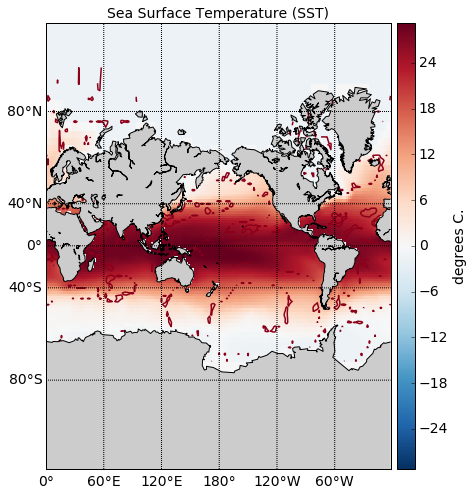

In [40]:
f = scalar_plot(sst, test=0.90, proj='merc').plot()

In [ ]:
scalar_plot(sst).plot

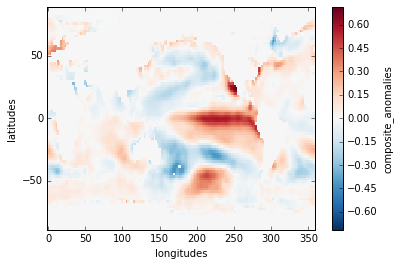

In [25]:
sst.dset.composite_anomalies.plot()

In [ ]:
sst.dset